In [1]:
import tp_knn_source as tpknn
import numpy as np
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

/home/thomas/.local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Génération artificielle de données

On considère dans cette partie des observations décrites en deux dimensions (afin de pouvoir les visualiser facilement) à savoir $p = 2$ dans le formalisme du sujet. On reprend en partie les jeux de données artificiels du TP sur le perceptron, avec des modifications sur les valeurs des étiquettes uniquement.

## Question 1

Étudiez les fonctions `rand_bi_gauss`, `rand_tri_gauss`, `rand_clown` et `rand_checkers`. Que renvoient ces fonctions ? À quoi correspond la dernière colonne ? Générez les données en utilisant
chaque de ces 4 fonctions avec les paramètres du corrigé du TP1 (pour `rand_checkers` générez
150 observations dans chaque classe ; pour `rand_tri_gauss` générez 50 observations dans chaque
classe, centrées en $(1, 1)^T$, $(−1, −1)^T$ et $(1, −1)^T$, tous les écart-types égaux à 0.9). On va nommer ces jeux de données #1, #2, #3 et #4, respectivement.

In [42]:
def get_distr1(n1, n2):
    mu1 = [1., 1.]
    mu2 = [-1., -1.]
    sigmas1 = [0.9, 0.9]
    sigmas2 = [0.9, 0.9]
    return tpknn.rand_bi_gauss(n1, n2, mu1, mu2, sigmas1, sigmas2)

X1, y1 = get_distr1(20, 20)

In [43]:
def get_distr2(n1, n2):
    sigmas1 = 1.
    sigmas2 = 5.
    return tpknn.rand_clown(n1, n2, sigmas1, sigmas2)
X3, y3 = get_distr2(50, 50)

In [44]:
def get_distr3(n1, n2):
    sigma = 0.1
    return tpknn.rand_checkers(n1, n2, sigma)
X4, y4 = get_distr3(150, 150)

In [45]:
def get_distr4(n1, n2, n3):
    mu1 = [1., 1.]
    mu2 = [-1., -1.]
    mu3 = [1., -1.]
    sigmas1 = [0.9, 0.9]
    sigmas2 = [0.9, 0.9]
    sigmas3 = [0.9, 0.9]
    return tpknn.rand_tri_gauss(n1, n2, n3, mu1, mu2, mu3, sigmas1, sigmas2, sigmas3)
X2, y2 = get_distr4(50, 50, 50)

## Question 2

Utilisez la fonction `plot_2d` afin d’afficher les jeux de données générés avec chacune des fonctions.

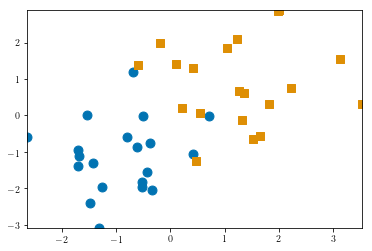

In [46]:
tpknn.plot_2d(X1, y1)

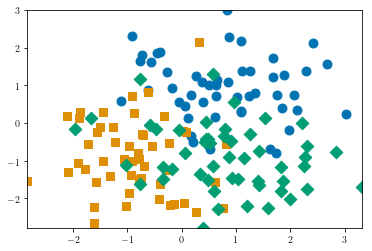

In [47]:
tpknn.plot_2d(X2, y2)

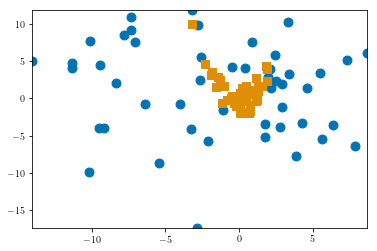

In [48]:
tpknn.plot_2d(X3, y3)

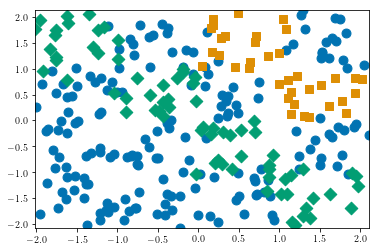

In [49]:
tpknn.plot_2d(X4, y4)

# K-plus proches voisins

## Approche intuitive
L’algorithme des $k$-plus proches voisins ($k$-nn : pour *k-nearest neighbors* en anglais) est un algorithme intuitif, aisément paramétrisable pour traiter un problème de classification avec un nombre quelconque d’étiquettes.

Le principe de l’algorithme est particulièrement simple : pour chaque nouveau point $x$ on commence par déterminer l’ensemble de ses $k$-plus proches voisins parmi les points d’apprentissage que l’on note $V_k(x)$ (bien sûr on doit choisir $1 \leq k \leq n$ pour que cela ait un sens). La classe que l’on affecte au nouveau point $x$ est alors la classe majoritaire dans l’ensemble $V_k(x)$. Une illustration de la méthode est donnée en Figure 1 pour le cas de trois classes.

### Question 3

Proposez une version adaptée de cette méthode pour la régression, i.e., quand les observations $y$ sont à valeurs réelles : $Y = \mathbb{R}$.

## Approche formelle

### Question 4

Écrivez votre propre classe `KNNClassifier` avec les méthodes d’apprentissage fit et de classification predict. Choisissez une stratégie de traitement des ex aequo, c’est-à-dire des points avec la même distance ou le même nombre de points de chaque classe dans $V_k(x)$. Vérifier la validité des résultats en les comparant à ceux de la classe `KNeighborsClassifier` de scikit-learn en utilisant le jeu de données #2. Vous proposerez votre propre méthode de comparaison (par exemple, en utilisant les observations d’indice pair pour le set d’apprentissage et celles d’indice impair pour le set de test). Vous pouvez utilisez le bloc de code ci-dessous en complétant le méthodes proposées. Pour plus d’information sur les classes on peut consulter par exemple http://docs.python.org/3/tutorial/classes.html.

In [10]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    n_neightbors = 0
    X = np.matrix([[]])
    y = np.matrix([[]])
    """ Homemade kNN classifier class """
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors
    def fit(self, X, y):
        self.X = X
        self.y = y
        return self

    def distance(self, x, y):
        return np.sqrt((x-y)@(x-y))

    def predict(self, x):
        distances = []
        for i in range(self.X.shape[0]):
            x_i = self.X[i]
            d = self.distance(x_i, x)
            distances.append([i, d])
        sorted_distances = sorted(distances, key=lambda d: d[1])
        k_distances = sorted_distances[:self.n_neighbors]
        k_labels = [self.y.item(k[0]) for k in k_distances]
        k_labels = np.matrix([k_labels])
        return stats.mode(k_labels.T)[0].item()


def split_data(X, y):
    return [
        X[::2],
        y[::2],
        X[1::2],
        y[1::2],
    ]


def test_algo(X, y, k):
    my_predictions = []
    scikit_predictions = []
    X_train, y_train, X_test, y_test = split_data(X, y)
    scikit_knn = KNeighborsClassifier(n_neighbors=k)
    scikit_knn.fit(X_train, y_train)
    my_knn = KNNClassifier(k).fit(X_train, y_train)
    print(y_test.shape, y_train.shape, y2.shape)
    for i in range(y_test.shape[0]):
        my_predictions.append(my_knn.predict(X_test[i]))
        
    scikit_predictions.append(scikit_knn.predict(X_test))
    return [my_predictions, scikit_predictions[0]]

In [11]:
my_preds, scikit_preds = test_algo(X2, y2, 3)
print(my_preds)
print(scikit_preds)
print(my_preds - scikit_preds)

(75,) (75,) (150,)
[3.0, 3.0, 1.0, 3.0, 2.0, 3.0, 2.0, 2.0, 3.0, 3.0, 2.0, 2.0, 1.0, 2.0, 3.0, 1.0, 1.0, 1.0, 1.0, 3.0, 2.0, 2.0, 3.0, 2.0, 2.0, 3.0, 2.0, 3.0, 1.0, 3.0, 3.0, 1.0, 3.0, 1.0, 1.0, 3.0, 3.0, 1.0, 3.0, 2.0, 2.0, 2.0, 1.0, 2.0, 3.0, 1.0, 1.0, 1.0, 3.0, 3.0, 1.0, 2.0, 1.0, 1.0, 3.0, 2.0, 3.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 1.0, 2.0]
[3. 3. 1. 3. 2. 3. 2. 2. 3. 3. 2. 2. 1. 2. 3. 1. 1. 1. 1. 3. 2. 2. 3. 2.
 2. 3. 2. 3. 1. 3. 3. 1. 3. 1. 1. 3. 3. 1. 3. 2. 2. 2. 1. 2. 3. 1. 1. 1.
 3. 3. 1. 2. 1. 1. 3. 2. 3. 1. 1. 1. 1. 3. 1. 2. 1. 1. 1. 3. 3. 3. 3. 3.
 3. 1. 2.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


### Question 5

Faites tourner sur les quatre exemples de jeu de données cet algorithme de classification, en utilisant la distance euclidienne classique $d(x, v) = \lVert x − v\rVert_2$ et $k = 5$. Visualisez les règles de classification obtenues en utilisant la fonction `frontiere_new`. (Souvent, les autres choix de distance peuvent être utiles, par exemple la distance de Mahalanobis.)

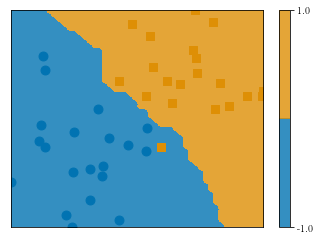

In [12]:
scikit_knn1 = KNeighborsClassifier(n_neighbors=5).fit(X1, y1)
def f1(vec):
    return scikit_knn1.predict(vec.reshape(1, -1))
tpknn.frontiere_new(f1, X1, y1)

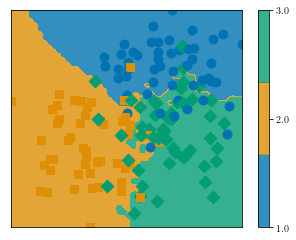

In [13]:
scikit_knn2 = KNeighborsClassifier(n_neighbors=5).fit(X2, y2)
def f2(vec):
    return scikit_knn2.predict(vec.reshape(1, -1))
tpknn.frontiere_new(f2, X2, y2)

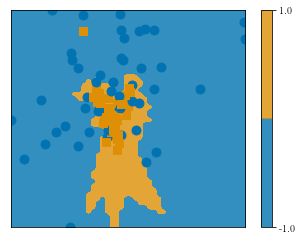

In [14]:
scikit_knn3 = KNeighborsClassifier(n_neighbors=5).fit(X3, y3)
def f3(vec):
    return scikit_knn3.predict(vec.reshape(1, -1))
tpknn.frontiere_new(f3, X3, y3)

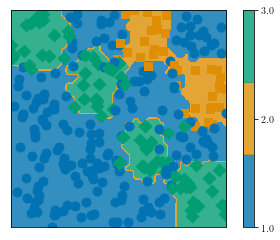

In [15]:
scikit_knn4 = KNeighborsClassifier(n_neighbors=5).fit(X4, y4)
def f4(vec):
    return scikit_knn4.predict(vec.reshape(1, -1))
tpknn.frontiere_new(f4, X4, y4)

### Question 6

Pour les observations d’indice pair du jeu de données #2, faites varier le nombre $k$ de voisins pris en compte : $k = 1, 2, . . . , n$. Que devient la méthode dans le cas extrême où $k = 1$ ? $k = n$ ? Afficher ces cas sur les données étudiées en utilisant la fonction `frontiere_new` et présentez les dans une forme facilement lisible. Dans quels cas la frontière est-elle complexe ? simple ?

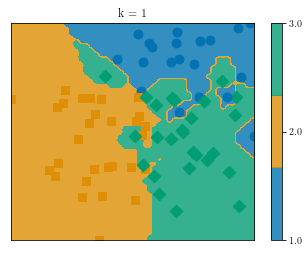

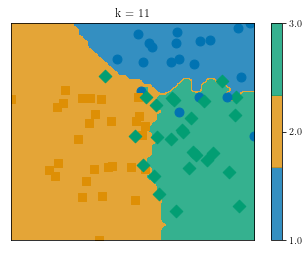

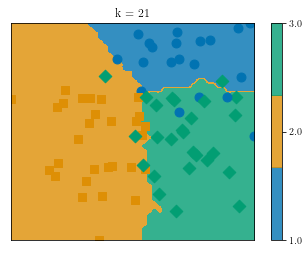

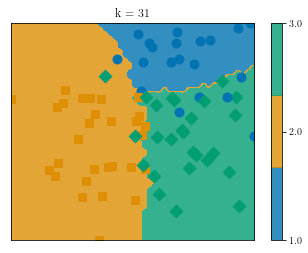

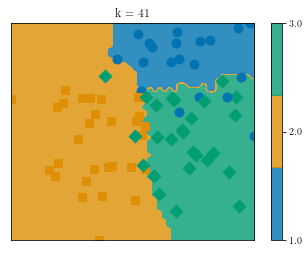

In [16]:



def q6(k):
    X = X2[::2]
    y = y2[::2]
    scikit_knn = KNeighborsClassifier(n_neighbors=k).fit(X, y)
    def f(vec):
        return scikit_knn.predict(vec.reshape(1, -1))
    
    tpknn.frontiere_new(f, X, y)
    
for i in range(1, 50, 10):
    plt.figure(i)
    plt.title("k = " + str(i))
    q6(i)

Text(0.5, 1.0, 'k = 50')

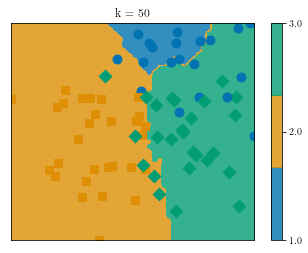

In [17]:
q6(50)
plt.title("k = 50")

### Question 7

Une variante possible très utilisée consiste à pondérer les poids du $j$-ème voisin selon $e^{−d^2_j/h}$ ($h$ contrôlant le niveau de pondération) : cela revient à remplacer l’Équation (2) par :

$$
\hat{f}_k(x) \in \operatorname*{argmax}_{y \in \mathcal{Y}} \left( \sum^k_{j=1} \exp(-d^2_j/h) \mathbb{1}_{\{y_{r_j}=y\}} \right)
$$

Implémentez cette variante dans scikit-learn en passant le paramètre weights au constructeurde `KNeighborsClassifier`. (Une autre possibilité consiste à pondérer les variables et non seulement les observations, on le regarde pas ici.) On pourra s’inspirer de `_weight_func` de la partie test de scikit-learn : https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/neighbors/tests/test_neighbors.py Pour tester l’impact du choix de $h$ sur les frontières de classification, visualisez les règles de classification pour $k = 7$ et $h = 10^j$ avec $j = −2, −1, 0, 1, 2$ ; utilisez les observations d’indice pair du jeux de données #2 pour l’entrainement du classifieur (Vous pouvez utiliser la fonction `frontiere_new`.)

In [18]:
from typing import List, Callable

# Returns a function
def create_get_weight(h: int) -> Callable[[List[float]], List[float]]:
    def get_weights(distances: List[float]) -> List[float]:
        return [np.exp(-d**2/h) for d in distances]
    return get_weights
 
def get_f(h, k, X, y):
    def f(vec):
        knn = KNeighborsClassifier(n_neighbors=k, weights=create_get_weight(h)).fit(X, y)
        return knn.predict(vec.reshape(1, -1))
    return f

def q7():
    k = 7
    js = [-2, -1, 0, 1, 2]
    hs = [10**j for j in js]
    X_train, y_train, X_test, y_test = split_data(X2, y2)
    
    i = 0
    for h in hs:
        plt.figure(i)
        j = js[i]
        plt.title(f"j = {j}; h = {h}")
        i += 1
        f = get_f(h, k, X_train, y_train)
        tpknn.frontiere_new(f, X_test, y_test)

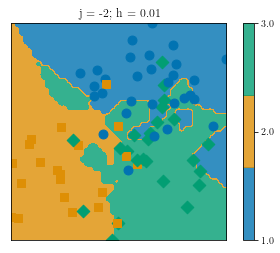

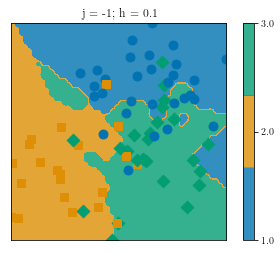

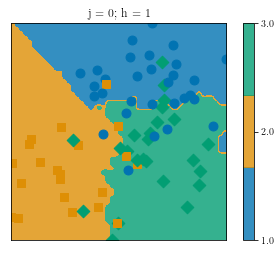

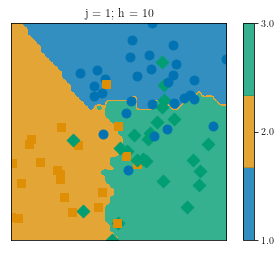

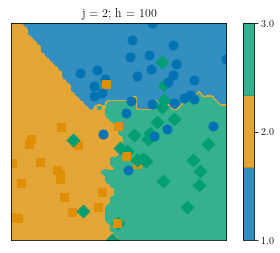

In [19]:
q7()

### Question 8

Quel est le taux d’erreur sur les mêmes données d’apprentissage (i.e., la proportion d’erreur faite par le classifieur) lorsque $k = 1$ ? et sur des données de test (les observations d’indice pair) ?

In [20]:
def get_error(y_pred, y):
    return np.sum(np.abs((y_pred - y) / 2))

def q8():
    X_train, y_train, X_test, y_test = split_data(X2, y2)
    knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
    y_pred_train = knn.predict(X_train)
    y_pred_test = knn.predict(X_test)
    print("Error on train set: ", get_error(y_pred_train, y_train))
    print("Error on test set: ", get_error(y_pred_test, y_test))
    
q8()

Error on train set:  0.0
Error on test set:  21.5


### Question 9

Pour le jeu de données #4, en utilisant les observations d’indice pair pour l’apprentissage et les observations d’indice impair pour le test, tracez le taux d’erreur en fonction de $k$ pour $k = 1, 2, . . . , 50$. Vous pourrez utiliser la classe fournie `ErrorCurve`.

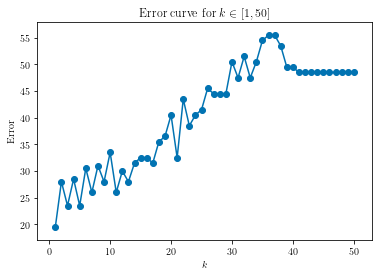

In [21]:
def q9():
    X_train, y_train, X_test, y_test = split_data(X4, y4)
    errors = []
    ks = list(range(1, 51))
    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        errors.append(get_error(y_pred, y_test))
    plt.plot(ks, errors)
    plt.scatter(ks, errors)
    plt.title("Error curve for $k \in [1, 50]$")
    plt.ylabel("Error")
    plt.xlabel("$k$")

q9()


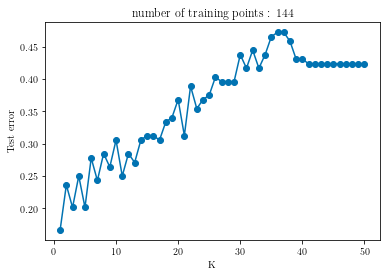

In [22]:
def q9_ErrorCurve():
    X_train, y_train, X_test, y_test = split_data(X4, y4)
    ks = list(range(1, 51))
    ec = tpknn.ErrorCurve(k_range=(ks))
    ec.fit_curve(X_train, y_train, X_test, y_test)
    ec.plot()
    
q9_ErrorCurve()

### Question 10

Tracez les différentes courbes d’erreur en fonction du paramètre $k = (1, 2, . . . , 50)$ sur le jeu de données #4, pour des nombres d’échantillons d’entrainement $n$ prenant les valeurs 100, 200, 500 à 1000. Cette fois, tirez l’ensemble d’apprentissage et l’ensemble de test indépendamment et de même taille. Quelle est la meilleure valeur de $k$ ? Est-ce la même pour les différents datasets ? Vous pourrez utiliser la classe fournie `ErrorCurve`. Pour $n = 1000$ visualisez les données et la règle de décision sur le même graphique. (Vous pouvez utiliser la `fonction frontiere_new`.)

(288, 2)


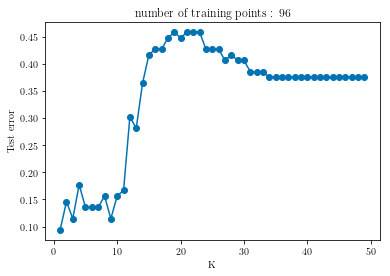

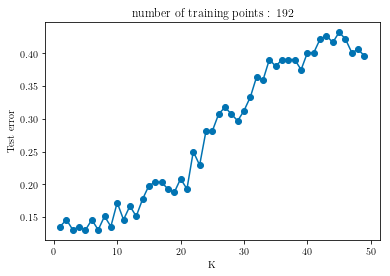

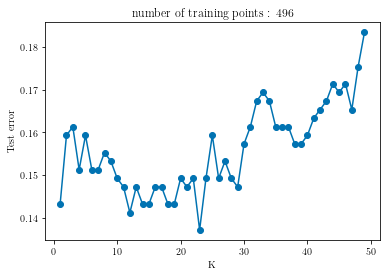

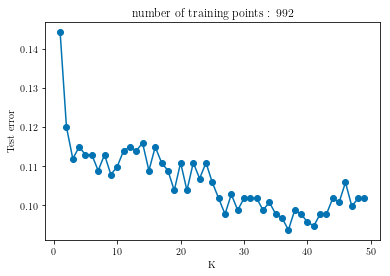

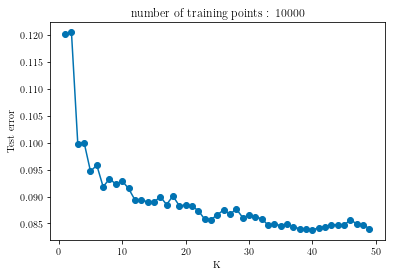

In [39]:
print(X4.shape)
import random

def get_bootstrap_sample(X, y, n):
    rows = np.random.randint(len(X) - 1, size=n)
    return [X[rows,:], y[rows]]

def get_sample(n):
    sigma = 0.1
    _n = int(n/2)
    return tpknn.rand_checkers(_n, _n, sigma)

def q10():
    k = list(range(1, 51))
    X = X4
    y = y4
    for i, n in enumerate([100, 200, 500, 1000, 10000]):
        # X_train, y_train = get_bootstrap_sample(X, y, n)
        # X_test, y_test = get_bootstrap_sample(X, y, n)
        X_train, y_train = get_sample(n)
        X_test, y_test = get_sample(n)
        ks = list(range(1, 50))
        ec = tpknn.ErrorCurve(k_range=(ks))
        ec.fit_curve(X_train, y_train, X_test, y_test)
        plt.figure(i)
        ec.plot()
        
q10()

### Question 11

A votre avis, quels sont les avantages et les inconvénients de la méthode des plus proches voisins : temps de calcul ? passage à l’échelle ? interprétabilité ?

Nous avons vu lors de l'implementation du $k$-plus proches voisins que l'algorithme doit parcourir tout l'espace des $X_{train}$ lors du calcul de chaque prédiction. Le passage à l'échelle est donc mauvais.

Cenpendant nous avons aussi vu lors sur les graphiques de la question précédente que le paramètre $k$ du classifieur *converge assez rapidement* meme avec peu de données (lorsque $k > 10$, augmenter $k$ ne réduit que de peu l'erreur). Evec une courbe cependant plus lisse lorsque $n$ est grand.

### Question 12

Étudiez la base digits de scikit-learn. On pourra se référer à http://scikit-learn.org/stable/_downloads/plot_digits_classification.py pour le chargement et la manipulation de la base de données. Pour de plus amples informations sur la nature de la classe 'Bunch' (une sous-classe de dictionnaire, on se reportera à la documentation sur la classe 'dict' : http://docs.python.org/2/library/stdtypes.html#mapping-types-dict. Décrivez la nature et le format des données (précisément), affichez un exemple. Tracez l’histogramme pour des classes. Coupez l’échantillon en deux parties de même taille et utilisez la première partie pour l’apprentissage et la deuxième pour le test. Appliquez la méthode aux données issues de la base digits pour un choix de k ≥ 1 (e.g., k = 30) et indiquez le taux d’erreur.

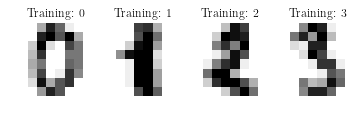

In [24]:
from sklearn import datasets

digits = datasets.load_digits()
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

La variable `digits` contient un dictionnaire composé des clefs suivantes:
- `images`: Elle contient un array composé d'images. Ces images sont elles meme des arrays 2D contentanant chacun 8 listes de 8 entiers. Ce sont l'intensité de noir (de 0 à 16) dans les 8 rangés de 8 pixels qui forment notre image
- 'data': La meme data que la clefs images, mais flattened. C'est donc un un array contenant les intensites de pixel des images mais flattened; dans un array 1D de 8*8=64 cases.
- 'target_names': La valeur des differentes classes
- 'target': Un array d'indexes correspondants aux classes associés à ce meme index dans les arrays image/data
- `DESCR`: plus d'infos

Autres infos:
- len(digits.data) = len(digits.images) = len(digits.target) = 1797
- Number of Classes = len(digits.target_names) 10

In [25]:
print(digits.data[0])
print(digits.images[0])


[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


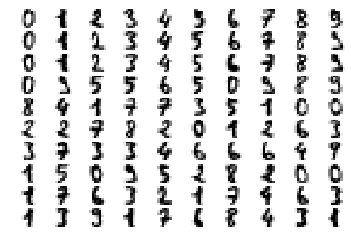

In [26]:
for index, (image, label) in enumerate(images_and_labels[:100]):
    plt.subplot(10, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

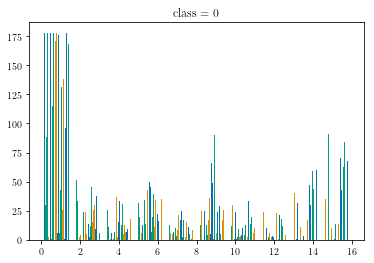

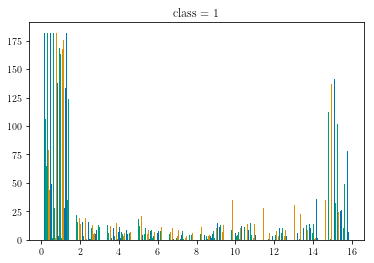

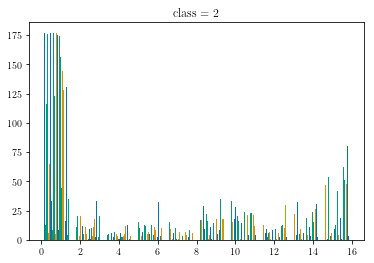

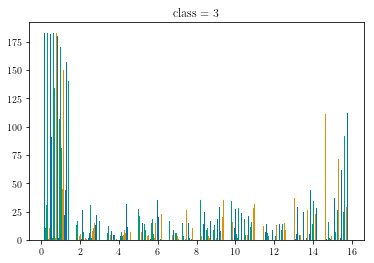

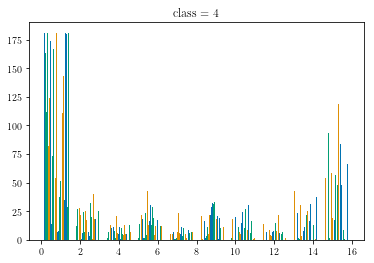

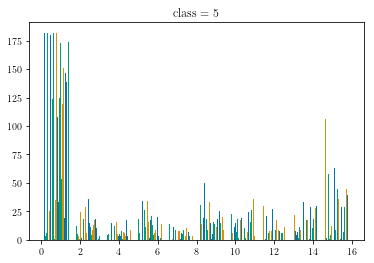

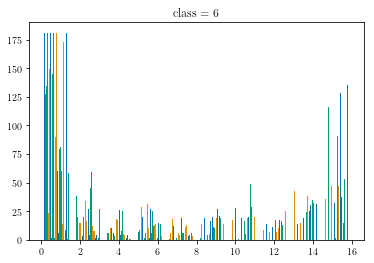

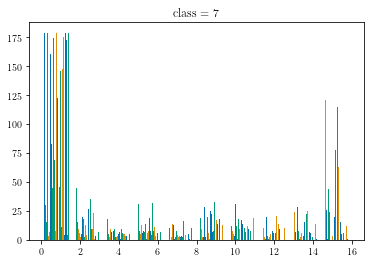

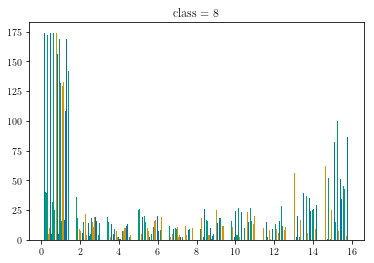

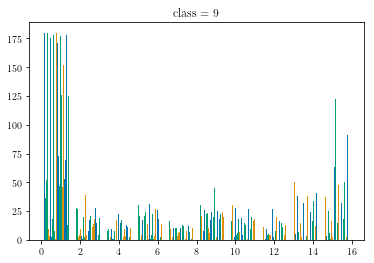

In [27]:
for i in range(10):
    plt.figure(i)
    plt.hist(digits.data[digits.target==i])
    plt.title("class = " + str(i))
    plt.plot()

In [28]:
def q12():
    X_train, y_train, X_test, y_test = split_data(digits.data, digits.target)

    knn = KNeighborsClassifier(n_neighbors=30).fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print("Number of elements in test sample:", len(y_train))
    print("Number of errors:", get_error(y_pred, y_test))
    
q12()

Number of elements in test sample: 899
Number of errors: 112.0


### Question 13

Estimez la matrice de confusion $(\mathbb{P}\{Y = i, C_k(X) = j\})_{i, j}$ associée au classifieur $C_k$ ainsi
obtenu et visualisez celle-ci. Pour la manipulation de telles matrices avec scikit-learn, on
pourra consulter http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html.

Confusion matrix, without normalization
[[88  0  0  0  0  0  0  0  0  0]
 [ 0 88  0  0  0  0  1  0  0  0]
 [ 1  1 84  0  0  0  0  1  4  0]
 [ 0  0  1 85  0  2  0  2  3  0]
 [ 0  0  0  0 87  0  0  0  1  0]
 [ 0  0  0  0  0 87  1  0  0  3]
 [ 0  0  0  0  0  0 90  0  0  0]
 [ 0  0  0  0  0  0  0 91  0  0]
 [ 0  5  2  1  0  2  1  0 75  0]
 [ 0  5  0  0  5  1  0  6  1 73]]


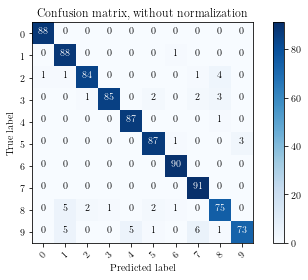

In [29]:
from sklearn.metrics import confusion_matrix
import itertools

# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def q13():
    X_train, y_train, X_test, y_test = split_data(digits.data, digits.target)
    knn = KNeighborsClassifier(n_neighbors=30).fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=digits.target_names,
                          title='Confusion matrix, without normalization')

q13()

On constate grace à la matrice de confusion que notre modèle se trompe relativement peu. Cependant, l'algorithme se trompe plus sur les classes 8 et 9 ainsi que les clases 2 et 3.

### Question 14

Proposez une méthode pour choisir k et mettez-la en œuvre. Vous pourrez utiliser la classe fournie `LOOCurve`. En utilisant toutes les données, tracez la courbe du taux d’erreur leave-one-out pour $k = 1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 100, 200$. Pour plus d’information sur la validation croisée (cross-validation) on peut consulter [HTF09, Chapitre 7.10].

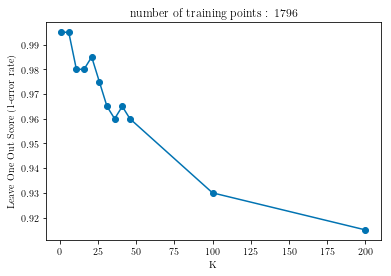

In [30]:
def q14():
    ks = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 100, 200]
    loo = tpknn.LOOCurve(k_range=ks)
    loo.fit_curve(digits.data, digits.target)
    loo.plot()
    
q14()

# Analyse Discriminante Linéaire

Le nom anglais est Linear Discirmiant Analysis (LDA). Il est préférable de se reporter à cette dénomination en vue de trouver de l’aide en ligne pour la partie numérique. Attention toutefois à ne pas confondre avec Latent Dirichlet Allocation qui est un modèle statistique hiérarchique pour données catégorielles et qui n’a pas de lien avec l’Analyse Discriminante Linéaire.

## Aspect Théorique

On considère deux populations gaussiennes dans $\mathbb{R}^p$ ayant la même structure de covariance. On observe des points dans le mélange de ces deux populations.

Les lois conditionnelles de $X$ sachant $Y = +1$ (respectivement $Y = −1$) sont des gaussiennes multivariées $\mathcal{N}(\mu_+, \Sigma)$ (respectivement $\mathcal{N}(\mu_-, \Sigma)$). On notera leurs densités respectives $f_+$ et $f_−$. Les vecteurs $μ_+$ et $μ_−$ sont dans $\mathbb{R}^p$ et la matrice $Σ$ est (symétrique) de taille $p\times p$. On note également $\pi_+ = \mathbb{P}\{Y = +1\}$. On rappelle que la densité $p$-dimensionnelle de la loi $\mathcal{N}(\mu, \Sigma)$ est donnée par :

$$
f(x) = \frac{1}{(2\pi)^{p/2}\sqrt{\det{\Sigma}}}\exp{\left\{ 
    -\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)
\right\}}
$$

et que la matrice de covariance d’un vecteur aléatoire $X$ est définie par $\Sigma = \mathbb{E}\left[ (X-\mathbb{E}X)(X-\mathbb{E}X)^T \right]$.

### Question 15

En utilisant la formule de Bayes donner la formule des probabilités a posteriori : $\mathbb{P}\{Y = +1 | X = x\}$,
$\mathbb{P}\{Y = −1 | X = x\}$, comme fonctions de $f_+$ , $f_−$ et $π_+$.

$$
\begin{align}
\mathbb{P}\{Y=+1|X=x\} &= \frac{\mathbb{P}\{X=x|Y=+1\}\mathbb{P}\{Y=+1\}}{\mathbb{P}\{X=x\}} \\
&= \frac{\mathbb{P}\{X=x|Y=+1\}\mathbb{P}\{Y=+1\}}{\mathbb{P}\{X=x|Y=+1\}\mathbb{P}\{Y=+1\} + \mathbb{P}\{X=x|Y=-1\}\mathbb{P}\{Y=-1\}} \\
&= \frac{f_+\pi_+}{f_+\pi_+ + f_-\pi_-} \\
&= \frac{f_+\pi_+}{f_+\pi_+ + f_-(1-\pi_+)}\\ \\
\mathbb{P}\{Y=-1|X=x\} &= \frac{\mathbb{P}\{X=x|Y=-1\}\mathbb{P}\{Y=-1\}}{\mathbb{P}\{X=x\}} \\
&= \frac{f_-(1-\pi_+)}{f_+\pi_+ + f_-(1-\pi_+)}
\end{align}
$$


### Question 16

Exprimer le log-ratio des deux classes :
    
$$
\log\left(
    \frac{\mathbb{P}\{Y=+1|X=x\}}{\mathbb{P}\{Y=-1|X=x\}}
\right)
$$

en fonction de $\pi_+, \mu_+, \mu_-$ et $\Sigma$

$$
\begin{align}
\log \left(\frac{\mathbb{P}\{Y=+1|X=x\}}{\mathbb{P}\{Y=-1|X=x\}}\right) &= \log\left(\frac{f_+\pi_+}{f_-(1-\pi_+)}\right) \\
&= \log\left[ \frac{
        \exp\left( -\frac{1}{2}(x-\mu_+)^T\Sigma^{-1}(x-\mu_+) \right)\pi_+ 
    }{
        \exp\left( -\frac{1}{2}(x-\mu_-)^T\Sigma^{-1}(x-\mu_-) \right)(1-\pi_+) 
    }\right] \\
&= -\frac{1}{2}\left[
    (x-\mu_+)^T\Sigma^{-1}(x-\mu_+) - (x-\mu_-)^T\Sigma^{-1}(x-\mu_-)
\right] + \log(\pi_+) - \log(1 - \pi_+)
\end{align}
$$

Par la symmétrie de $\Sigma^{-1}$ nous avons:

$$
\begin{align}
\log \left(\frac{\mathbb{P}\{Y=+1|X=x\}}{\mathbb{P}\{Y=-1|X=x\}}\right) 
    &= -\frac{1}{2}\left[
            x^T\Sigma^{-1}x - 2x^T\Sigma^{-1}\mu_+ + \mu_+^T\Sigma^{-1}\mu_+
            - (x^T\Sigma^{-1}x - 2x^T\Sigma^{-1}\mu_- + \mu_-^T\Sigma^{-1}\mu_-)
        \right] 
        + \log\left(\frac{\pi_+}{1 - \pi_+}\right) \\
    &= -\frac{1}{2}\left[
        2x^T\Sigma^{-1}(\mu_- - \mu_+) + \mu_+^T\Sigma^{-1}\mu_+ - \mu_-^T\Sigma^{-1}\mu_-
    \right] + \log\left(\frac{\pi_+}{1 - \pi_+}\right) \\
    &= x^T\Sigma^{-1}(\mu_+ - \mu_-) + \frac{1}{2}\mu_-^T\Sigma^{-1}\mu_- - \frac{1}{2}\mu_+^T\Sigma^{-1}\mu_+
    + \log\left(\frac{\pi_+}{1 - \pi_+}\right) \\
\end{align}
$$

On dispose à présent d’un échantillon de ce mélange et on suppose que $\pi_+, \mu_+, \mu_-$ et $\Sigma$ sont des paramètres inconnus. On suppose que l’échantillon considéré contient $n$ observations notées $(x_1,y_1),...,(x_n,y_n)$ et que $\sum^n_{i=1}\mathbb{1}\{y_i = +1\} = m$. On va utiliser les estimateurs sans biais $\hat{\pi}_+, \hat{\mu}_+, \hat{\mu}_-$ et $\hat{\Sigma}$ des paramètres :

$$
\hat{\pi}_+ = m/n \\
\hat{\mu}_+ = \frac{1}{m}\sum^n_{i=1}\mathbb{1}\{y_i = +1\}x_i \\
\hat{\mu}_- = \frac{1}{n - m}\sum^n_{i=1}\mathbb{1}\{y_i = -1\}x_i,
$$

Et:

$$
\hat{\Sigma} = \frac{1}{n - 2}((m-1)\hat{\Sigma}_+ + (n-m-1)\hat{\Sigma}_-)
$$

Avec:

$$
\hat{\Sigma}_+ = \frac{1}{m-1}\sum^n_{i=1}\mathbb{1}\{y_i = +1\}(x_i - \hat{\mu}_+)(x_i - \hat{\mu}_+)^T \\
\hat{\Sigma}_- = \frac{1}{n-m-1}\sum^n_{i=1}\mathbb{1}\{y_i = -1\}(x_i - \hat{\mu}_-)(x_i - \hat{\mu}_-)^T
$$

### Question 17

Justifier le choix du classifieur suivant : 1 si

$$
x^T\hat{\Sigma}^{-1}(\hat{\mu}_+ - \hat{\mu}_-)
>
    \frac{1}{2}\hat{\mu}_+^T\hat{\Sigma}^{-1}\hat{\mu}_+ 
    - \frac{1}{2}\hat{\mu}_-^T\hat{\Sigma}^{-1}\hat{\mu}_-
    + \log(1-m/n) - \log(m/n)
$$

Et -1 sinon.

Prennons le logarithme népérien du ratio de $\mathbb{P}\{Y=+1|X=x\}$ par $\mathbb{P}\{Y=-1|X=x\}$ comme estimateur. Nous avons donc:

$$
g_n(x) = \log \left(\frac{\mathbb{P}\{Y=+1|X=x\}}{\mathbb{P}\{Y=-1|X=x\}}\right)
$$

$g_n(x)$ sera alors superieur à 0 si $\mathbb{P}\{Y=+1|X=x\} > \mathbb{P}\{Y=-1|X=x\}$ et négatif si $e^{g_n(x)} \in (0,1)$. Il est donc pertinent d'assigner l'étiquette $+1$ si $g_n(x) > 0$ et $-1$ sinon. Estimons $g_n(x)$ par $\hat{g}_n(x)$ de la manière suivante:

$$
\hat{g}_n(x) = x^T\hat{\Sigma}^{-1}(\hat{\mu}_+ - \hat{\mu}_-)
    - \frac{1}{2}\hat{\mu}_+^T\hat{\Sigma}^{-1}\hat{\mu}_+ 
    + \frac{1}{2}\hat{\mu}_-^T\hat{\Sigma}^{-1}\hat{\mu}_-
    - \log(1-\hat{\pi}_+) 
    + \log(\hat{\pi}_+)
$$

Alors, si $\hat{g}_n(x) > 0$, c'est à dire quand notre classificateur retourne l'étiquette $+1$, nous obtenons:

$$
\begin{align}
&x^T\hat{\Sigma}^{-1}(\hat{\mu}_+ - \hat{\mu}_-)
    - \frac{1}{2}\hat{\mu}_+^T\hat{\Sigma}^{-1}\hat{\mu}_+ 
    + \frac{1}{2}\hat{\mu}_-^T\hat{\Sigma}^{-1}\hat{\mu}_-
    - \log(1-\hat{\pi}_+) 
    + \log(\hat{\pi}_+)
    > 0 \\
\therefore &
x^T\hat{\Sigma}^{-1}(\hat{\mu}_+ - \hat{\mu}_-)
    > \frac{1}{2}\hat{\mu}_+^T\hat{\Sigma}^{-1}\hat{\mu}_+ 
    - \frac{1}{2}\hat{\mu}_-^T\hat{\Sigma}^{-1}\hat{\mu}_-
    + \log(1-m/n) 
    - \log(m/n)
\end{align}
$$

Ce qui est bient le résultat à démontrer.


## Mise en oeuvre

### Question 18

Écrivez votre propre classe `LDAClassifier` avec les méthodes d’apprentissage `fit` et de classification `predict`.

In [55]:
from numpy.linalg import inv

class LDAClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        m = np.sum(y[y==1])
        n = y.shape[0]
        pi_plus = m/n
        mu_plus = 1/m * np.sum(X[np.where(y==1),:][0], axis=0).T
        mu_minus = 1/(n-m) * np.sum(X[np.where(y==-1),:][0], axis=0).T

        sig_plus = 1/(m-1) * (X[np.where(y==1),:][0]-mu_plus.T).T@(X[np.where(y==1),:][0]-mu_plus.T)
        sig_minus = 1/(n-m-1) * (X[np.where(y==-1),:][0]-mu_minus.T).T@(X[np.where(y==-1),:][0]-mu_minus.T)

        sig = 1/(n-2) * ((n-1)*sig_plus + (n-m-1)*sig_minus)
        sig_inv = inv(sig)

        t1 = 1/2*mu_plus.T@sig_inv@mu_plus
        t2 = 1/2*mu_minus.T@sig_inv@mu_minus
        self.test = t1 - t2 + np.log(1-pi_plus) - np.log(pi_plus)
        self.sig_inv = sig_inv
        self.mu_plus = mu_plus
        self.mu_minus = mu_minus

        return self

    def predict(self, X):
        y_pred = X@self.sig_inv@(self.mu_plus-self.mu_minus)
        y_pred[y_pred > 0] = 1
        y_pred[y_pred <= 0] = -1

        return y_pred

    def score(self, y_pred, y): 
        return y_pred[y_pred!=y].shape[0] / y.shape[0]

X = X1
y = y1
my_lda = LDAClassifier().fit(X, y)
y_pred = my_lda.predict(X)
print(my_lda.score(y_pred, y))


0.075


### Question 19

Importez le module `sklearn.discriminant_analysis` qui contient en particulier la classe `LinearDiscriminantAnalysis` qui nous servira dans la suite :

    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    
Vérifiez la validité des résultats obtenus avec votre méthode en les comparant à ceux de la classe `LinearDiscriminantAnalysis` de scikit-learn en utilisant un jeu de données simulé. Vous proposerez votre propre méthode de comparaison (l’échantillon d’apprentissage doit être petit et l’échantillon de validation doit être assez grand ; on considère par ailleurs que $m$ est différent de $n − m$, *i.e.*, les deux classes ne sont pas représentées par le même nombre d’échantillons observés). Indiquez les taux d’erreur de `LDAClassifier` et de `LinearDiscriminantAnalysis` et le nombre de cas où les
prédictions coïncident. En utilisant votre classe `LDAC`.

In [84]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def q19():
    n = 100
    m = int(n/2)
    X_train, y_train = get_distr1(n, m)
    X_test, y_test = get_distr1(4*n, 4*m)
    my_lda = LDAClassifier().fit(X_train, y_train)
    my_y_pred = my_lda.predict(X_test)
    sk_lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
    sk_y_pred = sk_lda.predict(X_test)
    print("My LDA classifier error:", my_lda.score(my_y_pred, y_test))
    print("SkLearn LDA classifier error:", my_lda.score(sk_y_pred, y_test))
    print("Predictions en accord:", my_y_pred[my_y_pred==sk_y_pred].shape[0])
    print("Predictions en désaccord:", my_y_pred[my_y_pred!=sk_y_pred].shape[0])
    
q19()

My LDA classifier error: 0.045
SkLearn LDA classifier error: 0.045
Predictions en accord: 600
Predictions en désaccord: 0


### Question 20

En utilisant votre classe `LDAClassifier`, visualisez la règle de classification pour les jeux de données #1 et #3. (Vous pouvez utiliser la fonction `frontiere_new`.) Discutez l’efficacité de la méthode dans ces deux cas.

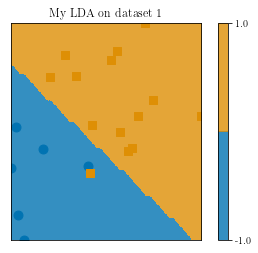

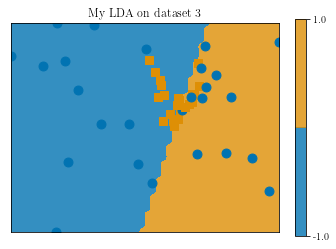

In [97]:
def q20(X, y):
    X_train, y_train, X_test, y_test = split_data(X, y)
    lda = LDAClassifier().fit(X_train, y_train)
    def f(vec):
        return lda.predict(vec.reshape(1, -1))
    
    tpknn.frontiere_new(f, X_test, y_test)

plt.figure()
plt.title("My LDA on dataset 1")
q20(X1, y1)

plt.figure()
plt.title("My LDA on dataset 3")
q20(X3, y3)

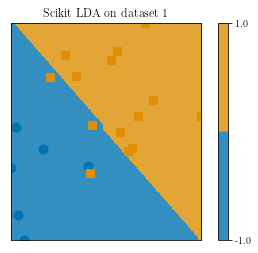

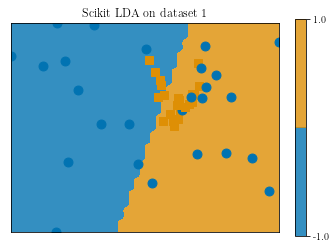

In [98]:
def q20_bis(X, y):
    X_train, y_train, X_test, y_test = split_data(X, y)
    lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
    def f(vec):
        return lda.predict(vec.reshape(1, -1))
    
    plt.title("Scikit LDA on dataset 1")
    tpknn.frontiere_new(f, X_test, y_test)

plt.figure()
plt.title("SkLearn LDA on dataset 1")
q20_bis(X1, y1)

plt.figure()
plt.title("SkLearn LDA on dataset 3")
q20_bis(X3, y3)

# Méthode discriminative avec régression logistique

Importer le module `sklearn.linear_model` qui contient en particulier la classe `LogisticRegression` qui nous servira dans la suite.

    from sklearn import linear_model
    
## Question 21

Appliquez la classification par régression logistique sur les données `rand_bi_gauss`. Comparer les résultats avec la LDA, notamment lorsque une classe est beaucoup plus petite que l’autre (a beaucoup moins d’observations). On parle alors de classes déséquilibrées.

In [ ]:
from sklearn import linear_model



## Question 22

À quoi correspond la variable `coef_` du modèle ? `intercept_` ?

## Question 23

Utiliser la fonction `frontiere_new` pour visualiser la frontière de décision.

## Question 24

Appliquez la classification par régression logistique à des données issues de la base digits. Comme précédemment, coupez l’échantillon en deux parties de même taille et utilisez la première partie pour l’apprentissage et la deuxième pour tester. Indiquez le taux d’erreur.